In [533]:
# Jc Lee

In [534]:
import numpy as np
import matplotlib
from scipy import ndimage
from skimage import color
import cv2  # opencv-python
import matplotlib.pyplot as plt

matplotlib.use('TkAgg')
%matplotlib inline

In [535]:
cameraman_path = 'cameraman.tif'
sarah_path = 'sarah.jpg'

In [536]:
frame_cameraman = plt.imread(cameraman_path)
frame_sarah = plt.imread(sarah_path)

In [537]:
print(f"Size of Sarah image: {frame_sarah.shape}")
print(f"Size of camerman image: {frame_cameraman.shape}")

Size of Sarah image: (250, 333, 3)
Size of camerman image: (256, 256)


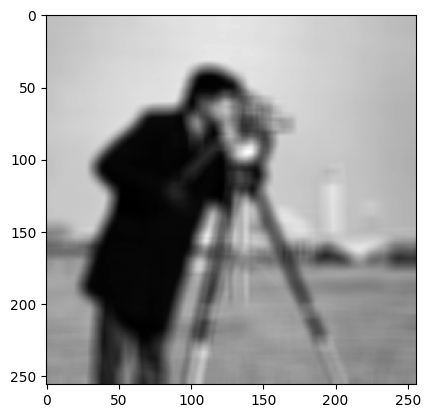

In [538]:
# Box filter (11,11)
N = 11;
# box filter is (n.n) one matrix scaled by the amount of elements: N*N
g_box = np.ones((N,N))/(N**2);

image = cv2.filter2D(frame_cameraman,-1,g_box);
plt.imshow(image, cmap=plt.cm.gray);

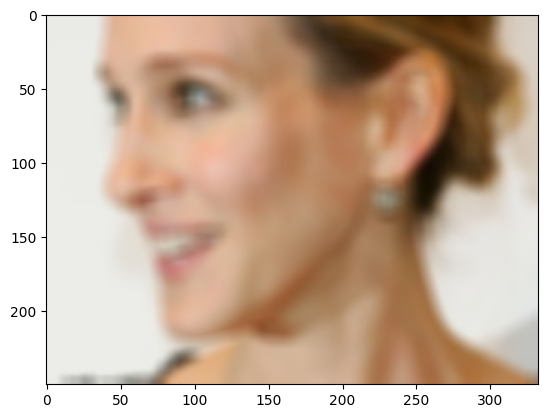

In [539]:
# Box filter on Sarah
image = cv2.filter2D(frame_sarah,-1,g_box);
plt.imshow(image);

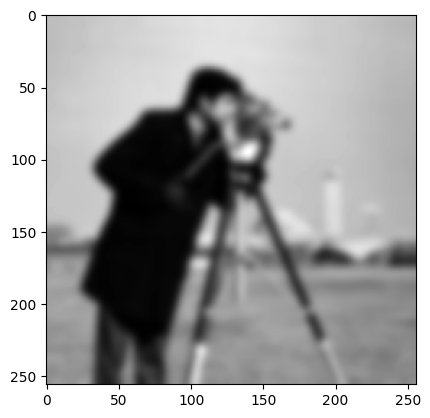

In [540]:
# Gaussian filter: sigma = 3, mu = 0, truncate_radius = 3

# using sigma=3 we need a kernel size of 19. We need (3*3) + (3*3) + 1
sigma = 3
truncate_sigma_radius = 3 # radius where the gaussian kernel is truncated. Generally 2-3sigma

# these parameters do not have to change (they are dependent on sigma)
kernel_radius = sigma*truncate_sigma_radius

# generates numbers spaced one apart with radius kernel_radius
v = np.linspace(-kernel_radius,kernel_radius, kernel_radius*2 + 1)
xx, yy = np.meshgrid(v, v)
# gaussian kernel
g = (1/(2*np.pi*sigma**2)) * np.exp(-1/(2*sigma**2) * (xx**2 + yy**2))
# normalizing gaussian kernel (sum of g should be 1 or else the kernel loses expressing power)
# losing expressing power normally means that the image colors will appear muted
g_gaussian = g / np.sum(g)

image = cv2.filter2D(frame_cameraman,-1,g_gaussian);
plt.imshow(image, cmap=plt.cm.gray);

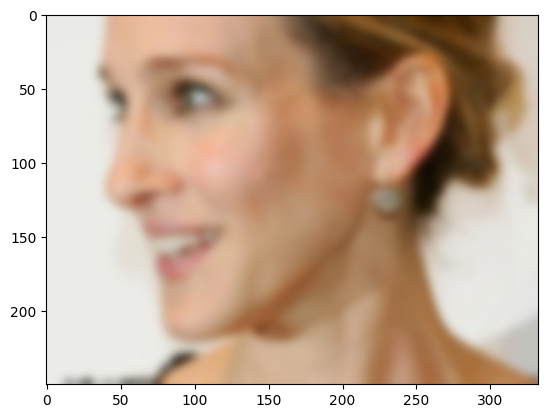

In [541]:
# gaussian filter on Sarah
image = cv2.filter2D(frame_sarah,-1,g_gaussian);
plt.imshow(image)

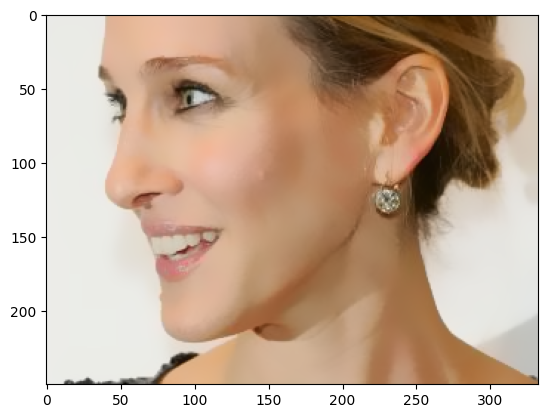

In [542]:
# Bilateral filtering
# This is just the gaussian with another comparison besides distance: pixel intensity
#img to filter
frame = plt.imread(sarah_path)
height = frame.shape[0]
width = frame.shape[1]

#adjustable parameters
sigma = 5
truncate_sigma_radius = 3

# pad edges of image with 0 for edge case handling
kernel_radius = sigma*truncate_sigma_radius
pad_width = ((kernel_radius, kernel_radius), (kernel_radius, kernel_radius), (0,0))
frame = np.pad(frame, pad_width, mode='constant', constant_values=0)

# convert rgb to CIELAB
flattened_rgb = frame / 255.0
frame = color.rgb2lab(frame)

# we take the gaussian kernel from the previous part
#*******PREVIOUS PART STARTS HERE**********
v = np.linspace(-kernel_radius,kernel_radius, kernel_radius*2 + 1)
xx, yy = np.meshgrid(v, v)
g = (1/(2*np.pi*sigma**2)) * np.exp(-1/(2*sigma**2) * (xx**2 + yy**2))
#*******PREVIOUS PART ENDS HERE**********

Ip = np.ones((kernel_radius*2 + 1, kernel_radius*2 + 1, 3))
# making g three dimensions (transpose is needed for the proper shape)
g = np.tile(g, (3,1,1)).T

# our image starts at kernel radius
image = np.zeros((height, width, 3))
for i in range(height):
    for j in range(width):
        # reset all Ip values to 1
        Ip = np.ones_like(Ip)
        # scales I to where the kernel is centered. broadcasting should do the job of scaling properly
        Ip *= frame[kernel_radius+i, kernel_radius+j, :]
        # subtracts the image slice with the top right of i-kernel_radius, j-kernel_radius from I to get intensity diff
        Iq = frame[i : i+kernel_radius*2+1, j : j+kernel_radius*2+1, :]

        # Gaussian of I (Gaussian in a single dimension)
        I = (1/(2*np.pi*sigma**2)**(1/2)) * np.exp(-1/(2*sigma**2) * ((Ip - Iq)**2))

        # value wise multiplication between g and I
        combined_matrix = np.multiply(g, I)
        # values wise multiplication between the res of g*I and each individual pixel
        pre_sum = np.multiply(combined_matrix, Iq)
        pre_row_sum = np.sum(pre_sum, axis = 0)
        sum = np.sum(pre_row_sum, axis = 0, keepdims=True)

        # calculating Wp
        Wp_pre_row_sum = np.sum(combined_matrix, axis = 0)
        Wp = np.sum(Wp_pre_row_sum, axis = 0)

        #value wise multiplication between Wp and sum
        BF = np.multiply((1/Wp), sum)

        #set each layer of image to desired value
        image[i,j,:] = BF[:]

#convert CIELAB colors of image to rgb
rgb_image = color.lab2rgb(image)

plt.imshow(rgb_image)